# Predicting Boston Home Prices and the effectiveness of the Learning Rate

Using the Boston Home Prices dataset from Sci-kit learn, we will use three different models to predict home prices and compare their accuracy. We will demonstrate the effect that Learning Rate has on Boosting Algorithms specifically. 

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')
%matplotlib inline

#### Load Data from Sci-kit Learn:

In [5]:
boston = load_boston()

In [6]:
# House Prices:
y = boston.target

# The other 13 features:
x = boston.data

#### Explore the dataset:

In [8]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

#### Create a Training and Test set for our predictive models: 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=1)

#### Create 3 Models:
 * Random Forrest Ensemble with 100 estimators
 * Gradient Boosting Regressor (will dial-in the learning rate later), least-squares loss function, 100 estimators)
 * Adaptive Boost Regressor with a decision tree regressor as your base estimator

In [12]:
rf = RandomForestRegressor(n_estimators=100,
                            n_jobs=-1,
                            random_state=1)

gdbr = GradientBoostingRegressor(learning_rate=0.1,
                                  loss='ls',
                                  n_estimators=100,
                                  random_state=1)

abr = AdaBoostRegressor(DecisionTreeRegressor(),
                         learning_rate=0.1,
                         loss='linear',
                         n_estimators=100,
                         random_state=1)

#### Create a cross validation score function for each model:

In [10]:
def cvs(model,x_data,y_data):
    '''
    Returns Mean MSE and R-squared value for a 5-split cross-validation
    '''
    mse = np.mean(-1*cross_val_score(model,x_data,y_data,cv=5,scoring='neg_mean_squared_error'))
    r2 = np.mean(cross_val_score(model,x_data,y_data,cv=5,scoring='r2'))
    return mse, r2

In [13]:
rf_mse, rf_r2 = cvs(rf, X_train, y_train)
gdbr_mse, gdbr_r2 = cvs(gdbr, X_train,y_train)
abr_mse, abr_r2 = cvs(abr, X_train,y_train)

#### Compare the MSE and R2 for each model:

In [15]:
print("{:26s} {} | MSE: {:2.3f} | R2: {:2.3f}".format('RandomForestRegressor','TRAIN CV',rf_mse, rf_r2))
print("{:26s} {} | MSE: {:2.3f} | R2: {:2.3f}".format('GradientBoostingRegressor','TRAIN CV',gdbr_mse, gdbr_r2))
print("{:26s} {} | MSE: {:2.3f} | R2: {:2.3f}".format('AdaBoostRegressor','TRAIN CV',abr_mse, abr_r2))

RandomForestRegressor      TRAIN CV | MSE: 9.803 | R2: 0.874
GradientBoostingRegressor  TRAIN CV | MSE: 10.864 | R2: 0.864
AdaBoostRegressor          TRAIN CV | MSE: 9.540 | R2: 0.876


#### Make a Gradient Boosting model with a learning rate of 1 and compare the result to the previous gdbr:

In [16]:
gdbr_1 = GradientBoostingRegressor(learning_rate=1,
                                  loss='ls',
                                  n_estimators=100,
                                  random_state=1)

In [17]:
gdbr_1_mse, gdbr_1_r2 = cvs(gdbr_1, X_train,y_train)

In [20]:
print("{:28s} {} | MSE: {:2.3f} | R2: {:2.3f}".format('GradientBoostingRegressor_1','TRAIN CV',gdbr_1_mse, gdbr_1_r2))

GradientBoostingRegressor_1  TRAIN CV | MSE: 18.702 | R2: 0.762


#### Make function that plots the predictions and at each stage of the boosting algorithm.
Plot both of the MSE for the predictions on the training data as well as the test data:

In [22]:
def stage_score_plot(estimator, ax, X_train, y_train, X_test, y_test):
    '''
    Parameters: estimator: GradientBoostingRegressor or AdaBoostRegressor
                X_train: 2d numpy array
                y_train: 1d numpy array
                X_test: 2d numpy array
                y_test: 1d numpy array

    Returns: A plot of the number of iterations vs the MSE for the model for
    both the training set and test set.
    '''
    estimator.fit(X_train,y_train)
    y_staged_predict_train = estimator.staged_predict(X_train)
    y_staged_predict_test = estimator.staged_predict(X_test)
    mse_train=[]
    mse_test=[]
    for y_pred in y_staged_predict_train:
        mse_train.append(mean_squared_error(y_train, y_pred))

    for y_pred in y_staged_predict_test:
        mse_test.append(mean_squared_error(y_test, y_pred))

    x = np.arange(0,100,1)
    ax.plot(x,mse_train,label="{} Training Data, learning rate: {}".format(estimator.__class__.__name__,estimator.learning_rate))
    ax.plot(x,mse_test,label="{} Testing Data, learning rate: {}".format(estimator.__class__.__name__,estimator.learning_rate))

#### Plot the random forest evaluation as well (horizontal line):

In [27]:
def rf_score_plot(randforest, ax, X_train, y_train, X_test, y_test):
    '''
        Parameters: randforest: RandomForestRegressor
                    X_train: 2d numpy array
                    y_train: 1d numpy array
                    X_test: 2d numpy array
                    y_test: 1d numpy array
        Returns: The prediction of a random forest regressor on the test set
    '''
    randforest.fit(X_train, y_train)
    y_test_pred = randforest.predict(X_test)
    test_score = mean_squared_error(y_test, y_test_pred)
    ax.axhline(test_score, alpha = 0.7, c = 'y', lw=3, ls='-.', label = 
                                                        'Random Forest Test')

#### Plot the Boosting Regressor (both test and training data) that has a learning rate of 1, along-side the Boosting Regressor that has a rate of 0.1 and the Random Forrest

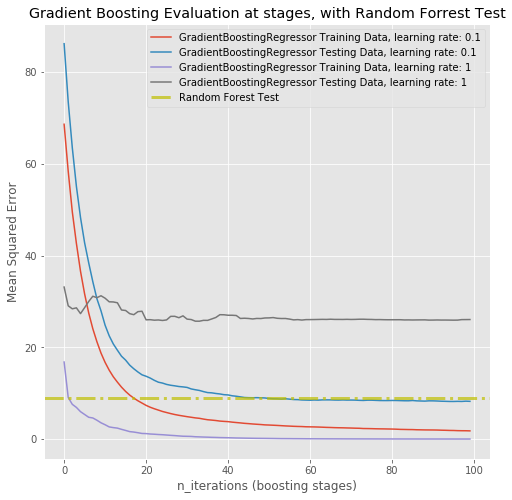

In [42]:
fig, ax = plt.subplots(1, figsize=(8,8))

#Feed the function the boosting algo that has learning_rate = 1:
stage_score_plot(gdbr, ax, X_train, y_train, X_test, y_test)

#Feed the function the boosting algo that has learning_rate = 0.1:
stage_score_plot(gdbr_1, ax, X_train, y_train, X_test, y_test)

#Add a horizontal line for our Random Forrest model on the test data:
rf_score_plot(rf, ax, X_train, y_train, X_test, y_test)

ax.set_title('Gradient Boosting Evaluation at stages, with Random Forrest Test')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('n_iterations (boosting stages)')
plt.legend()
plt.show()

#### As you can see, the a slower learning rate will (as the name suggests, slow the learning of our model) and require us to use more iterations. A faster learning rate appears to over-fit the data